In [32]:
#For surf features using we need this version it is only available til python 3.7
!pip install -r ../requirements.txt

In [33]:
import cv2 as cv
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from active_semi_clustering.semi_supervised.pairwise_constraints import PCKMeans,COPKMeans, MPCKMeansMF, MPCKMeans
from active_semi_clustering.active.pairwise_constraints import ExampleOracle, ExploreConsolidate, MinMax
import active_semi_clustering.active.pairwise_constraints.random
import pickle
import shap
import imagehash
from PIL import Image
from operator import itemgetter

In [34]:
builder = tfds.builder('voc/2007')
builder.download_and_prepare()
datasets = builder.as_dataset()
train_data, val_data, test_data = datasets['train'], datasets['validation'], datasets['test']

In [35]:
#hyperparamets
rows_cld=8
columns_cld=8


def create_zigzag_flat(rows,columns):
    a=np.arange(0,rows*columns,1,dtype=int).reshape((rows,columns))
    #needed to extact the diagonals because they can only go left to right
    a=np.flipud(a)
    flip=1
    diagonal=[]
    for i in range(1-rows, columns):
        diagonal.append(np.diagonal(a,i)[::flip])
        flip=-flip
    return np.concatenate(diagonal)  
    
zigzag_flat = create_zigzag_flat(rows_cld,columns_cld)


def color_layout_descriptor(im):
    # numpy is a bit faster than using tensors
    im = np.array(im)
    # could do these as a hyperparameter
    rows = rows_cld
    columns = columns_cld
    small_image = np.zeros((rows, columns, 3))
    height, width = im.shape[:2]
    percentage_w = width / columns
    percentage_h = height / rows
    for row in range(rows):
        for column in range(columns):
            # Note this partion should propably be checked against a reference implementation. However the difference should be minimal
            portion = im[int(percentage_h * row):int(percentage_h * (row + 1)),
                      int(percentage_w * column):int(percentage_w * (column + 1))]
            small_image[row, column] = np.mean(np.mean(portion, axis=0), axis=0)
            
    small_image = cv.cvtColor(small_image.astype(np.uint8), cv.COLOR_RGB2BGR)
    small_image = cv.cvtColor(small_image.astype(np.uint8), cv.COLOR_BGR2YCrCb)
    y, cr, cb = cv.split(small_image)
    dct_y = cv.dct(y.astype(np.float32))
    dct_cb = cv.dct(cb.astype(np.float32))
    dct_cr = cv.dct(cr.astype(np.float32))
    return np.concatenate((dct_y.flatten()[zigzag_flat], dct_cb.flatten()[zigzag_flat], dct_cr.flatten()[zigzag_flat]))

In [36]:
#0.01203213019504501  for 64 ahash
#0.011844196784313301 for 32 ahash
#0.007797600576972058 for 16 ahash
#performs bettetter even if euclidian distance is technically wrong here
def difference_hashing(im):
    hashed_img = imagehash.average_hash(Image.fromarray(im.numpy().astype(np.uint8)),hash_size=32)

    imhash = np.array(list(str(hashed_img)))
    
    converted_hash = []
    n = 0
    for i in imhash:
        converted_hash.append(float.fromhex(imhash[n]))
        n = n + 1
    
    out_hash = np.array(converted_hash)/16.0
    #print("image hash:", imhash)
    #print("hash converted to array:", out_hash)
    
    return out_hash


In [37]:
_VOC_LABELS = (
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
)

In [38]:
#helper functions
def calculate_label_area(objects,labels):
        obj_labels=objects["label"]
        obj_boundingbox=objects["bbox"]
        return calculate_label_area_helper(obj_labels,obj_boundingbox,labels)
    
def calculate_label_area_helper(obj_labels,obj_boundingbox,labels):
        areas=[]
        for label in labels:
            area_estimate=0
            foundbbox=[]
            for k,boundinglabel in enumerate(obj_labels):
                if(boundinglabel!=label): continue
                y_min,x_min,y_max,x_max=obj_boundingbox[k]
                #Here we could calulate the overlap to the other boxes
                area_estimate+=(y_max-y_min)*(x_max-x_min)
            areas.append(area_estimate)
        return areas 
    
def get_max_label_helper(obj_labels,obj_boundingbox,labels):
        areas=calculate_label_area_helper(obj_labels,obj_boundingbox,labels)
        max_arg,_=max(enumerate(areas), key=itemgetter(1))
        return labels[max_arg]

def get_max_label(objects,labels):
        obj_labels=objects["label"]
        obj_boundingbox=objects["bbox"]
        return get_max_label_helper(obj_labels,obj_boundingbox,labels)

In [39]:
import ipywidgets as widgets
import asyncio
from IPython.display import display
import time


#this is only an estimate because overlap is not considered
#TODO correcly calculate overlap


from active_semi_clustering.active.pairwise_constraints.example_oracle import MaximumQueriesExceeded


class LabelOracle:
    def __init__(self, data, max_queries_cnt=100,max_querry=False,area_difference_weight=1.0,different_labels_weight=2):
        self.data = data
        self.queries_cnt = 0
        self.max_queries_cnt = max_queries_cnt
        self.different_labels_weight=different_labels_weight
        self.area_difference_weight=area_difference_weight
        if(max_querry):
            self.query=self.query_max
        else:
            self.query=self.query_heuristic


    def query_heuristic(self, i, j):
        "Query the oracle to find out whether i and j should be must-linked"
        if self.queries_cnt < self.max_queries_cnt:
            self.queries_cnt += 1
            set_a=set(self.data[i]["labels"])
            set_b=set(self.data[j]["labels"])
            sameclasses=set_a.intersection(set_b)
            only_a=set_a-set_b
            only_b=set_b-set_a
            if(len(sameclasses)==0) :return False
            same_area_i=sum(calculate_label_area(self.data[i]["objects"],sameclasses))
            same_area_j=sum(calculate_label_area(self.data[j]["objects"],sameclasses))
            
            diff_area_i=sum(calculate_label_area(self.data[i]["objects"],only_a))
            diff_area_j=sum(calculate_label_area(self.data[j]["objects"],only_b))
            areaquot=same_area_i/same_area_j
            if(areaquot<1):
                areaquot=1.0/areaquot
            score1=1/(1+self.area_difference_weight*areaquot)
            #heuristics 2 depends on share of similiar clases to difference clasesses
            difference_adjusted_i=diff_area_i/same_area_i
            difference_adjusted_j=diff_area_j/same_area_j
            #heuristics are multiplied
            score2=1/(1+self.different_labels_weight*(difference_adjusted_j+difference_adjusted_i))
            score12=score1*score2
            if(score12<0.1):
                if(score12>0.05):
                    #print(set_a)
                    #print(set_b)
                    #print(score1)
                    #print(difference_adjusted_i)
                    #print(difference_adjusted_j)
                    #print(score2)
                    #print(score12)
                    #f, ax = plt.subplots(1,2) 
                    #ax[0].imshow(self.data[i]["image"])
                    #ax[1].imshow(self.data[j]["image"])
                    #plt.show()
                    pass
                return False
            return True                  
                            
        else:
            raise MaximumQueriesExceeded
    #helps with evaluation because the result depends only on one label so labeled cluster evaultion methods can be used       
    def query_max(self, i, j):
        "Query the oracle to find out whether i and j should be must-linked"
        if self.queries_cnt < self.max_queries_cnt:
            self.queries_cnt += 1
            max_label_i=get_max_label(self.data[i]["objects"],self.data[i]["labels"])
            max_label_j=get_max_label(self.data[j]["objects"],self.data[j]["labels"])
            #if((max_label_i == self.data[j]["labels"][max_arg_j])):
                    #f, ax = plt.subplots(1,2) 
                    #ax[0].imshow(self.data[i]["image"])
                    #ax[1].imshow(self.data[j]["image"])
                    #plt.show()
            return max_label_i == max_label_j      
        else:
            raise MaximumQueriesExceeded

    

# y for must link, everything else is cannot link
class ExpertOracle:
    def __init__(self, data, max_queries_cnt=100):
        self.data = data
        self.queries_cnt = 0
        self.max_queries_cnt = max_queries_cnt

    def query(self, i, j):
        "Query the oracle to find out whether i and j should be must-linked"
        if self.queries_cnt < self.max_queries_cnt:
            self.queries_cnt += 1
            #return len(set(self.labels[i]).intersection(set(self.labels[j])))>0
            
            #The synchronised content blocks while waiting for unsynchronized one, not sure if there is a way around this
            #x = asyncio.run(f(self.buttonAcc,self.buttonRej))
            
            #now i use busy waiting which needs another thread
            f, ax = plt.subplots(1,2) 
            ax[0].imshow(self.data[i]["image"])
            ax[1].imshow(self.data[j]["image"])
            plt.show()
            x=input() 
            clear_output(wait=True)
            if x=="y":
                return True
            else:
                
                return False
     
        else:
            raise MaximumQueriesExceeded
#Press Button for answer, needs seperate thread            
from IPython.display import clear_output            
            
class ExpertOracle2:
    def __init__(self, data, max_queries_cnt=100):
        self.data = data
        self.queries_cnt = 0
        self.max_queries_cnt = max_queries_cnt
        self.buttonAcc=widgets.Button(description="Must Link")
        self.buttonRej=widgets.Button(description="Cannot Link")
        self.buttonAcc.on_click(self.retTrue)
        self.buttonRej.on_click(self.retFalse)
        self.result=-1
        

    def retTrue(a,b):
         a.result=1
    def retFalse(a,b):
         a.result=0    

    def query(self, i, j):
        "Query the oracle to find out whether i and j should be must-linked"
        if self.queries_cnt < self.max_queries_cnt:
            self.queries_cnt += 1
            #return len(set(self.labels[i]).intersection(set(self.labels[j])))>0
            
            #The synchronised content blocks while waiting for unsynchronized one, not sure if there is a way around this
            #x = asyncio.ensure_future(f(self.buttonAcc,self.buttonRej))
            
            #now i use busy waiting which needs another thread
            display(widgets.HBox([self.buttonAcc,self.buttonRej]))
            f, ax = plt.subplots(1,2) 
            ax[0].imshow(self.data[i]["image"])
            ax[1].imshow(self.data[j]["image"])
            plt.show()
            
            while(self.result==-1):
                time.sleep(0.05)
                pass
            clear_output(wait=True)
            if self.result== 1:
                self.result=-1
                return True
            else:
                self.result=-1
                return False
        else:
            raise MaximumQueriesExceeded


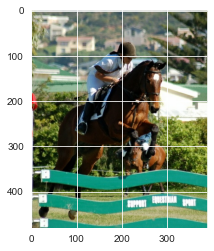

(256,)


In [40]:
for x in train_data:
    image = x["image"]
    plt.imshow(image)
    plt.show()
    print(difference_hashing(image).shape)
    break

In [41]:

LOAD_CONSTRAINTS=False

# Disable enable Features here

CLD_ENABLED = True

EFFNET_ENABLED = True

HASHING_ENABLED = True

SURF_ENABLED = True

ORB_ENABLED = True

enabled_names = []
feature_weights=[]

if CLD_ENABLED:
    enabled_names.append("cld")
    feature_weights.append(0.0065)
    

if EFFNET_ENABLED:
    enabled_names.append("effnet")
    feature_weights.append(2)

pooling="avg"


if HASHING_ENABLED:
    enabled_names.append("hash")
    feature_weights.append(0.45)

if SURF_ENABLED:
    enabled_names.append("surf")
    feature_weights.append(1.0)
    
if ORB_ENABLED:
    enabled_names.append("orb")
    feature_weights.append(1.0)

In [42]:
effnet = tf.keras.applications.EfficientNetV2B1(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=pooling,
    classes=1000,
    classifier_activation="softmax",
    include_preprocessing=True,
)


In [43]:

from scipy.spatial import distance
import time


class KMajority:
    def __init__(self,n_clusters=8,max_iter=100,):
        
        self.n_cluster=n_clusters
        self.max_iter=max_iter
        
    def fit(self,X,y=None,centroid=None):
        X=np.array(X, dtype=bool)
        #random centriods
        if centroid is None:
            centroids=np.random.randint(2, size=(self.n_cluster,X.shape[1]))
            self.centroids=np.array(centroids, dtype=bool)
        else:
            self.centroids=centroid
        centroids=None
            
        for i in range(self.max_iter):
            #distance from each point in X and the centroids so ouput is shape (number_samples, number_clusters)
            number_samples =X.shape[0]
            number_features=X.shape[1]
            
            dist=distance.cdist(X,self.centroids,'hamming')
            #shape (number_samples,)
            cluster_assigned=np.argmin(dist,axis=1)
            
            
            #we calculate one hot encodings to select the rows we want to sum over using matrix multiplication
            #test=np.zeros((X.shape[0],self.n_cluster))
            #test[np.arange(X.shape[0]),cluster_assigned]=1
            #out=test.T@X
            
            row_sum = np.array([X[cluster_assigned==i].sum(axis=0) for i in range(self.n_cluster)])
            row_count = np.array([(cluster_assigned==i).sum(axis=0) for i in range(self.n_cluster)])

            #print(row_sum)
            #print(row_count)
            new_centroids=row_sum>(row_count/2).reshape(-1,1)
            #remove empty clusering init randomly again nets bad results but setting it to actual points helps
            nullcheck=row_count==0
            if(np.any(nullcheck)):
                for k in np.argwhere(nullcheck):
                    #does not work to bad performance in comparision to already fitted clusters
                    #zw=np.random.randint(2, size=(X.shape[1]))
                    
                    index = np.random.choice(X.shape[0], 1, replace=False) 
                    new_centroids[k[0]]=X[index]
                    
            #print(centroids[0])
            #print(new_centroids[0])
            print(i)
            if(np.array_equal(self.centroids,new_centroids)):
                self.labels=cluster_assigned
                self.centroids=new_centroids
                return self
            
            self.labels=cluster_assigned
            self.centroids=new_centroids
            
        return self
            
    def predict(self,X):
        X=np.array(X, dtype=bool)
            #distance from each point in X and the centroids so ouput is shape (number_samples, number_clusters)
        number_samples =X.shape[0]
        number_features=X.shape[1]
        dist=distance.cdist(X,self.centroids,'hamming')
        cluster_assigned=np.argmin(dist,axis=1)
        return cluster_assigned

In [44]:
#Preparing surf features

surf_clusers=1000
if SURF_ENABLED:
        surf = cv.xfeatures2d.SURF_create(hessianThreshold = 25,upright =True,extended  =True)
        def calculate_surf_image(surf,img):
            kp = surf.detect(img,None)
            kp, des = surf.compute(img, kp)
            return des

        def calculate_surf(image_list):
            des=list(map(lambda x : calculate_surf_image(surf,x),image_list))
            return np.vstack(des)

        try: 
            with open("data/k_means_surf.pkl", "rb") as f:
                k_means_surf = pickle.load(f)
        except:
            image_list = list(train_data.map(lambda x: x['image']).as_numpy_iterator())
            descriptors=calculate_surf(image_list)
            print(len(descriptors))
            from sklearn.cluster import MiniBatchKMeans
            k_means_surf=MiniBatchKMeans(n_clusters=surf_clusers,reassignment_ratio=0.02,n_init=4,max_iter=200,batch_size=10000)
            print("test")
            start=time.time()

            k_means_surf.fit(descriptors)
            print(time.time()-start)
            print(metrics.calinski_harabasz_score(descriptors, k_means_surf.predict(descriptors)))
            
            with open("data/k_means_surf.pkl", "wb") as f:
                pickle.dump(k_means_surf, f)
                
        def calculate_bow(ima):
            histogram=np.zeros((surf_clusers))
            des=calculate_surf_image(surf,ima.numpy().astype(np.uint8))
            index=k_means_surf.predict(des)
            np.add.at(histogram,index,1)
            return histogram
        
orb_clusters=1000   
if ORB_ENABLED:  
    orb= cv.ORB_create()
    def calculate_orb_image(orb,image):
        kp = orb.detect(image,None)
        kp, des = orb.compute(image, kp)
        return des

    def calculate_orb(image_list):
        des=list(map(lambda x : calculate_orb_image(x),image_list))
        return np.vstack(des)
    
    try: 
        with open("data/dumped_kmajority.pkl", "rb") as f:
                k_majority_orb = pickle.load(f)
    except Exception as e:
        print(str(e))
        print("Our K majority implemention is to slow to run here. Please use stored weights")
        ORB_ENABLED=False
    
    
    def calculate_bow_orb(ima):
        histogram=np.zeros((orb_clusters))
        des=calculate_orb_image(orb,ima.numpy().astype(np.uint8))
        des=np.unpackbits(des, axis = 1)
        index=k_majority_orb.predict(des)
        print(index)
        np.add.at(histogram,index,1)
        return histogram



In [45]:
#histogram=histogram/histogram.sum(axis=1,keepdims=True)
#for image in image_list:
    #calculate_bow(image)

In [46]:
from sklearn.decomposition import PCA
def get_all_features(datapoint):
    return tf.concat([datapoint[enabled_names[i]]*feature_weights[i] for i in range(len(enabled_names))],0)


class DatasetPreprocessor:
    def __init__(self):
        self.norm1=None
        self.norm2=None
        self.norm3=None
        self.norm4=None
        self.norm5=None
        self.pca1=None
        self.pca2=None
        self.pca3=None
        self.fitted=False

        
    def add_features_to_dataset(self,dataset,cachename,fit=False):
        if(self.fitted==False and fit==False):
            print("fit before use")
            raise Exception()
        self.fitted=True 
        images = dataset.map(lambda x: x["image"])
        feature_sets = []

        # order is important here, must be same as defined in enabled_names
        if CLD_ENABLED:
            cld_features = images.map(lambda x: tf.py_function(func=color_layout_descriptor, inp=[x], Tout=np.float32),
                                      num_parallel_calls=tf.data.experimental.AUTOTUNE).cache("data/"+cachename+"_cld" if cachename!=None else '').prefetch(
                tf.data.experimental.AUTOTUNE)
            shape=cld_features.take(1).get_single_element().shape
            cld_features = cld_features.map(lambda t: tf.ensure_shape(t,shape)).cache("data/"+cachename+"_cld2" if cachename!=None else '').prefetch(
                tf.data.experimental.AUTOTUNE)
            if fit==True:
                self.norm1=tf.keras.layers.Normalization();
                self.norm1.adapt(cld_features)
            cld_features=cld_features.map(lambda x:self.norm1(x))
            feature_sets.append(cld_features)
            

        if EFFNET_ENABLED:
            resized_images = dataset.map(lambda x: tf.image.resize(x["image"], [240, 240])).batch(1024)
            effnet_features = resized_images.map(lambda x: effnet(x)).cache().unbatch().cache("data/"+cachename+"_effnet" if cachename!=None else '').prefetch(
                tf.data.experimental.AUTOTUNE)

            if fit==True:
                self.norm2=tf.keras.layers.Normalization();
                self.norm2.adapt(effnet_features)
                self.pca = PCA(n_components=320) 
                effnet_list = np.array(list(effnet_features.as_numpy_iterator()))
                self.pca.fit(effnet_list)
            effnet_features= effnet_features.map(lambda x:self.norm2(x))  
            effnet_features= effnet_features.map(lambda x: tf.reshape(tf.py_function(func=self.pca.transform, inp=[tf.reshape(x,(1, -1))], Tout=np.float32),[-1]),
                                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
            feature_sets.append(effnet_features)
            

        if HASHING_ENABLED:
            hashing_features = images.map(lambda x: tf.py_function(func=difference_hashing, inp=[x], Tout=np.float32),
                                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
            shape=hashing_features.take(1).get_single_element().shape
            hashing_features = hashing_features.map(lambda t: tf.ensure_shape(t,shape)).cache("data/"+cachename+"_hash" if cachename!=None else '').prefetch(
                tf.data.experimental.AUTOTUNE)
            if fit==True:
                self.norm3=tf.keras.layers.Normalization();
                self.norm3.adapt(hashing_features)
            hashing_features=hashing_features.map(lambda x:self.norm3(x))
            feature_sets.append(hashing_features)
            
            

        if SURF_ENABLED:
            surf_features = images.map(lambda x: tf.py_function(func=calculate_bow, inp=[x], Tout=np.float32),
                                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
            surf_features = surf_features.map(lambda t: tf.ensure_shape(t,(surf_clusers,))).cache("data/"+cachename+"_surf" if cachename!=None else '')
            if fit==True:
                self.norm4=tf.keras.layers.Normalization();
                self.norm4.adapt(surf_features)
                self.pca2 = PCA(n_components=250) 
                surf_list = np.array(list(surf_features.as_numpy_iterator()))
                self.pca2.fit(surf_list)
                
            surf_features=surf_features.map(lambda x:self.norm4(x))
            surf_features=surf_features.map(lambda x: tf.reshape(tf.py_function(func=self.pca2.transform, inp=[tf.reshape(x,(1, -1))], Tout=np.float32),[-1]),
                                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
            feature_sets.append(surf_features)
            
            
        if ORB_ENABLED:
            orb_features = images.map(lambda x: tf.py_function(func=calculate_bow_orb, inp=[x], Tout=np.float32),
                                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
            orb_features = orb_features.map(lambda t: tf.ensure_shape(t,(orb_clusters,))).cache("data/"+cachename+"_orb" if cachename!=None else '')
            if fit==True:
                self.norm5=tf.keras.layers.Normalization();
                self.norm5.adapt(orb_features)
                self.pca3 = PCA(n_components=250) 
                orb_list = np.array(list(orb_features.as_numpy_iterator()))
                self.pca3.fit(orb_list)
                
            orb_features=orb_features.map(lambda x:self.norm5(x))
            orb_features=orb_features.map(lambda x: tf.reshape(tf.py_function(func=self.pca3.transform, inp=[tf.reshape(x,(1, -1))], Tout=np.float32),[-1]),
                                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
            feature_sets.append(orb_features)
            


        # We could do feature scaling here
        # this here insers the values of all featuresets into the dictionary
        complete_dataset = tf.data.Dataset.zip((dataset,) + tuple(feature_sets)).map(
            lambda x, *y: x.update({enabled_names[i]: y[i] for i in range(len(enabled_names))})\
            or x, num_parallel_calls=tf.data.experimental.AUTOTUNE).map(lambda x:x.update({"feature":get_all_features(x)}) or x, num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(tf.data.experimental.AUTOTUNE)
        # I dediced to return dict here. They have the advantage that you can disable/add Features add will without having to condider ordering. Also we do not loose any information, which we might use later
        return complete_dataset

data_pre=DatasetPreprocessor()
# after first run this should be cached memory (needs full run)
train_complete = data_pre.add_features_to_dataset(train_data,"train",fit=True)
val_complete = data_pre.add_features_to_dataset(val_data, "val")


#PrefetchDataset element_spec=TensorSpec(shape=(1280,)

In [47]:
# forces caching
counter=0
for i in train_complete:
    counter+=1
    pass
for i in val_complete:
    pass
print(counter)

2501


In [48]:
for i in train_complete:
    print(i.keys())
    print(len(i["feature"]))
    break

dict_keys(['image', 'image/filename', 'labels', 'labels_no_difficult', 'objects', 'cld', 'effnet', 'hash', 'surf', 'orb', 'feature'])
1268


In [49]:
def filter_dataset(dataset,number_neighboors):
    train_knn_arr = np.array(list(dataset.map(lambda x:tf.reshape(tf.image.resize(x["image"],[200,200]),[-1])).as_numpy_iterator()))
    def get_KNN_points(numb_neigh, query_point, X):
        neigh = NearestNeighbors(n_neighbors=numb_neigh).fit(X)
        dist_arr, ind_array = neigh.kneighbors(X=X[query_point].reshape(1, -1))
        return ind_array.flatten('c')
    filter_ind=get_KNN_points(number_neighboors,0,train_knn_arr)
    filter_arr=np.zeros((train_knn_arr.shape[0]))
    filter_arr[filter_ind]=1
    filter_arr=tf.convert_to_tensor(filter_arr, np.uint8)
    return dataset.enumerate().filter(lambda x,y:filter_arr[x]==1).\
        map(lambda x,y:y)

In [50]:
train_filtered=filter_dataset(train_complete,500)
train_filtered_list=list(train_filtered.as_numpy_iterator())
len(train_filtered_list)

500

In [51]:
n_cluster=20
from sklearn.preprocessing import StandardScaler
# uses the label with estimated maximum size
y = list(train_filtered.map(lambda x: (x['objects']['label'],x['objects']['bbox'],x['labels'])).map(lambda x,y,z:tf.py_function(func=get_max_label_helper, inp=[x,y,z], Tout=np.int64),num_parallel_calls=tf.data.AUTOTUNE).as_numpy_iterator())
features = np.array(list(train_filtered.map(lambda x: x['feature']).as_numpy_iterator()), dtype=np.float64)



In [53]:
test_feature_1 = np.array(list(train_filtered.map(lambda x: x['surf']).as_numpy_iterator()), dtype=np.float64)
test_feature_2 = np.array(list(train_filtered.map(lambda x: x['effnet']).as_numpy_iterator()), dtype=np.float64)
test_feature_3 = np.array(list(train_filtered.map(lambda x: x['cld']).as_numpy_iterator()), dtype=np.float64)
test_feature_4 = np.array(list(train_filtered.map(lambda x: x['hash']).as_numpy_iterator()), dtype=np.float64)
test_feature_5 = np.array(list(train_filtered.map(lambda x: x['orb']).as_numpy_iterator()), dtype=np.float64)

In [ ]:
#1280 is best w

In [54]:
def test_for_querry(data,filtered_list,n_cluster,y,power_of_query_count=5,tries=1,use_explore_consolidate=False):
    values_random=[]
    values_sil=[]
    querry_counts=[]
    for i in range (power_of_query_count):
        cnt=100*(2**(i))
        querry_counts.append(cnt)
        values_random_per_try=[]
        values_sil_per_try=[]

        for k in range(tries):

            #Gives way more constraints by trying to find neighboorhoods, but ammount is random
            #active_learner = active_semi_clustering.active.pairwise_constraints.explore_consolidate.ExploreConsolidate(n_clusters=20)
            fitted=False
            while (not fitted):
                oracle = LabelOracle(filtered_list, max_queries_cnt=cnt,max_querry=True)
                if(use_explore_consolidate):
                     active_learner = active_semi_clustering.active.pairwise_constraints.explore_consolidate.ExploreConsolidate(n_clusters=n_cluster)
                else:
                    active_learner = active_semi_clustering.active.pairwise_constraints.random.Random(n_clusters=n_cluster)
                active_learner.fit(data, oracle)
                pairwise_constraints = active_learner.pairwise_constraints_
                pck = PCKMeans(n_clusters=n_cluster,max_iter=100,w=500)
                try:
                    pck.fit(data, ml=pairwise_constraints[0], cl=pairwise_constraints[1])
                    values_random_per_try.append(metrics.adjusted_rand_score(y, pck.labels_))
                    values_sil_per_try.append(metrics.silhouette_score(data, pck.labels_, metric='euclidean'))
                    fitted=True
                except Exception as e:
                    if str(e) == "KeyboardInterrupt":
                        raise
                    else:
                        print(str(e))
                    pass
        values_random.append(values_random_per_try)
        values_sil.append(values_sil_per_try)
        print(np.mean(values_random_per_try))
        print(np.mean(values_sil_per_try))
    return values_random,values_sil,querry_counts







In [65]:
start=time.time()
import tmp_func
import multiprocessing
pool = multiprocessing.Pool(processes=8)
kwargs={"power_of_query_count":5,"tries":9}
kwargs2={"power_of_query_count":4,"tries":9,"use_explore_consolidate":False}
kwargs3={"power_of_query_count":4,"tries":9,"use_explore_consolidate":True}
async_result1=pool.apply_async(tmp_func.task,(features,train_filtered_list,n_cluster,y),kwargs)
async_result2=pool.apply_async(tmp_func.task,(test_feature_1,train_filtered_list,n_cluster,y),kwargs)
async_result3=pool.apply_async(tmp_func.task,(test_feature_2,train_filtered_list,n_cluster,y),kwargs)
async_result4=pool.apply_async(tmp_func.task,(test_feature_3,train_filtered_list,n_cluster,y),kwargs)
async_result5=pool.apply_async(tmp_func.task,(test_feature_4,train_filtered_list,n_cluster,y),kwargs)
async_result6=pool.apply_async(tmp_func.task,(test_feature_5,train_filtered_list,n_cluster,y),kwargs)
async_result7=pool.apply_async(tmp_func.task,(features,train_filtered_list,n_cluster,y),kwargs2)
async_result8=pool.apply_async(tmp_func.task,(features,train_filtered_list,n_cluster,y),kwargs3)

values_random,values_sil,querry_counts = async_result1.get(timeout=1800)
print("1")
print(time.time()-start)
values_random_surf,values_sil_surf,querry_counts = async_result2.get(timeout=1800)
print("2")
print(time.time()-start)
values_random_effnet,values_sil_effnet,querry_counts = async_result3.get(timeout=1800)
print("3")
print(time.time()-start)
values_random_cld,values_sil_cld,querry_counts=async_result4.get(timeout=1800)
print("4")
print(time.time()-start)
values_random_hash,values_sil_hash,querry_counts=async_result5.get(timeout=1800)
print("5")
print(time.time()-start)
values_random_orb,values_orb_hash,querry_counts=async_result6.get(timeout=1800)
values_random_random,values_sil_random,querry_counts2 = async_result7.get(timeout=1800)
print("7")
print(time.time()-start)
values_random_explore,values_sil_explore,querry_counts2 = async_result8.get(timeout=1800)
print("8")
pool.close()
pool.join()
print(time.time()-start)

1
623.1180446147919
2
650.5430264472961
3
650.5430264472961
4
718.7589316368103
5
718.7589316368103
7
718.7599291801453
8
905.0242402553558


[[0.019784496172573347, 0.020655793563519202],
 [0.028133279902606802, 0.02426801698370402],
 [0.02746004605995531, 0.027740290968629813],
 [0.04471993617642272, 0.04299823976250205],
 [0.05301989930893345, 0.11098119074934136]]

In [56]:
#start=time.time()
#values_random,values_sil,querry_counts=test_for_querry(features,train_filtered_list,n_cluster,y)
#values_random_surf,values_sil_surf,querry_counts=test_for_querry(test_feature_1,train_filtered_list,n_cluster,y)
#values_random_effnet,values_sil_effnet,querry_counts=test_for_querry(test_feature_2,train_filtered_list,n_cluster,y)
#values_random_cld,values_sil_cld,querry_counts=test_for_querry(test_feature_3,train_filtered_list,n_cluster,y)
#values_random_hash,values_sil_hash,querry_counts=test_for_querry(test_feature_4,train_filtered_list,n_cluster,y)
#print(time.time()-start)

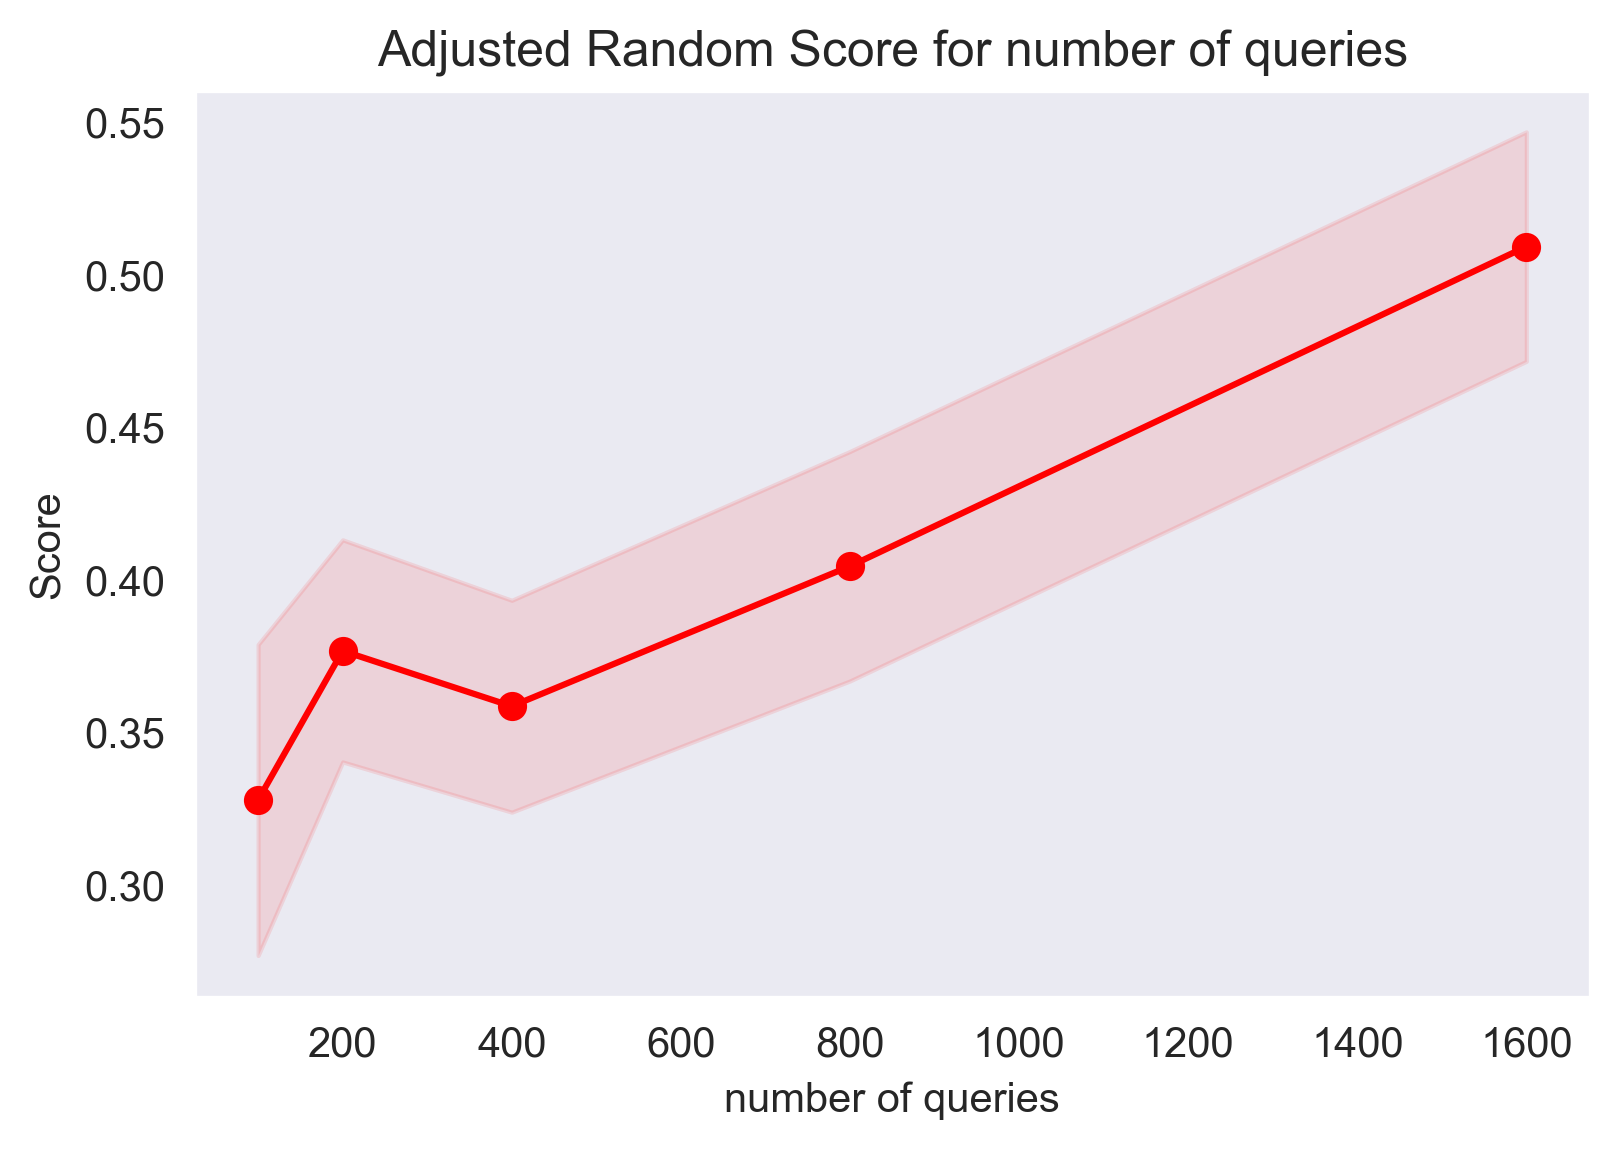

In [66]:
fig, ax = plt.subplots(1, 1)
fig.dpi=300
ax.set_title("Adjusted Random Score for number of queries")
ax.set_xlabel("number of queries")
ax.set_ylabel("Score")
score_arr=np.array(values_random)
train_scores_mean = np.mean(score_arr, axis=1)
train_scores_std = np.std(score_arr, axis=1)
ax.grid()
ax.fill_between(querry_counts, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
ax.plot(querry_counts, train_scores_mean, 'o-', color="r",
            label="Training score")
#ax.tick_params(labelsize=text_fontsize)
#ax.legend(loc="best", fontsize=text_fontsize)
plt.show()

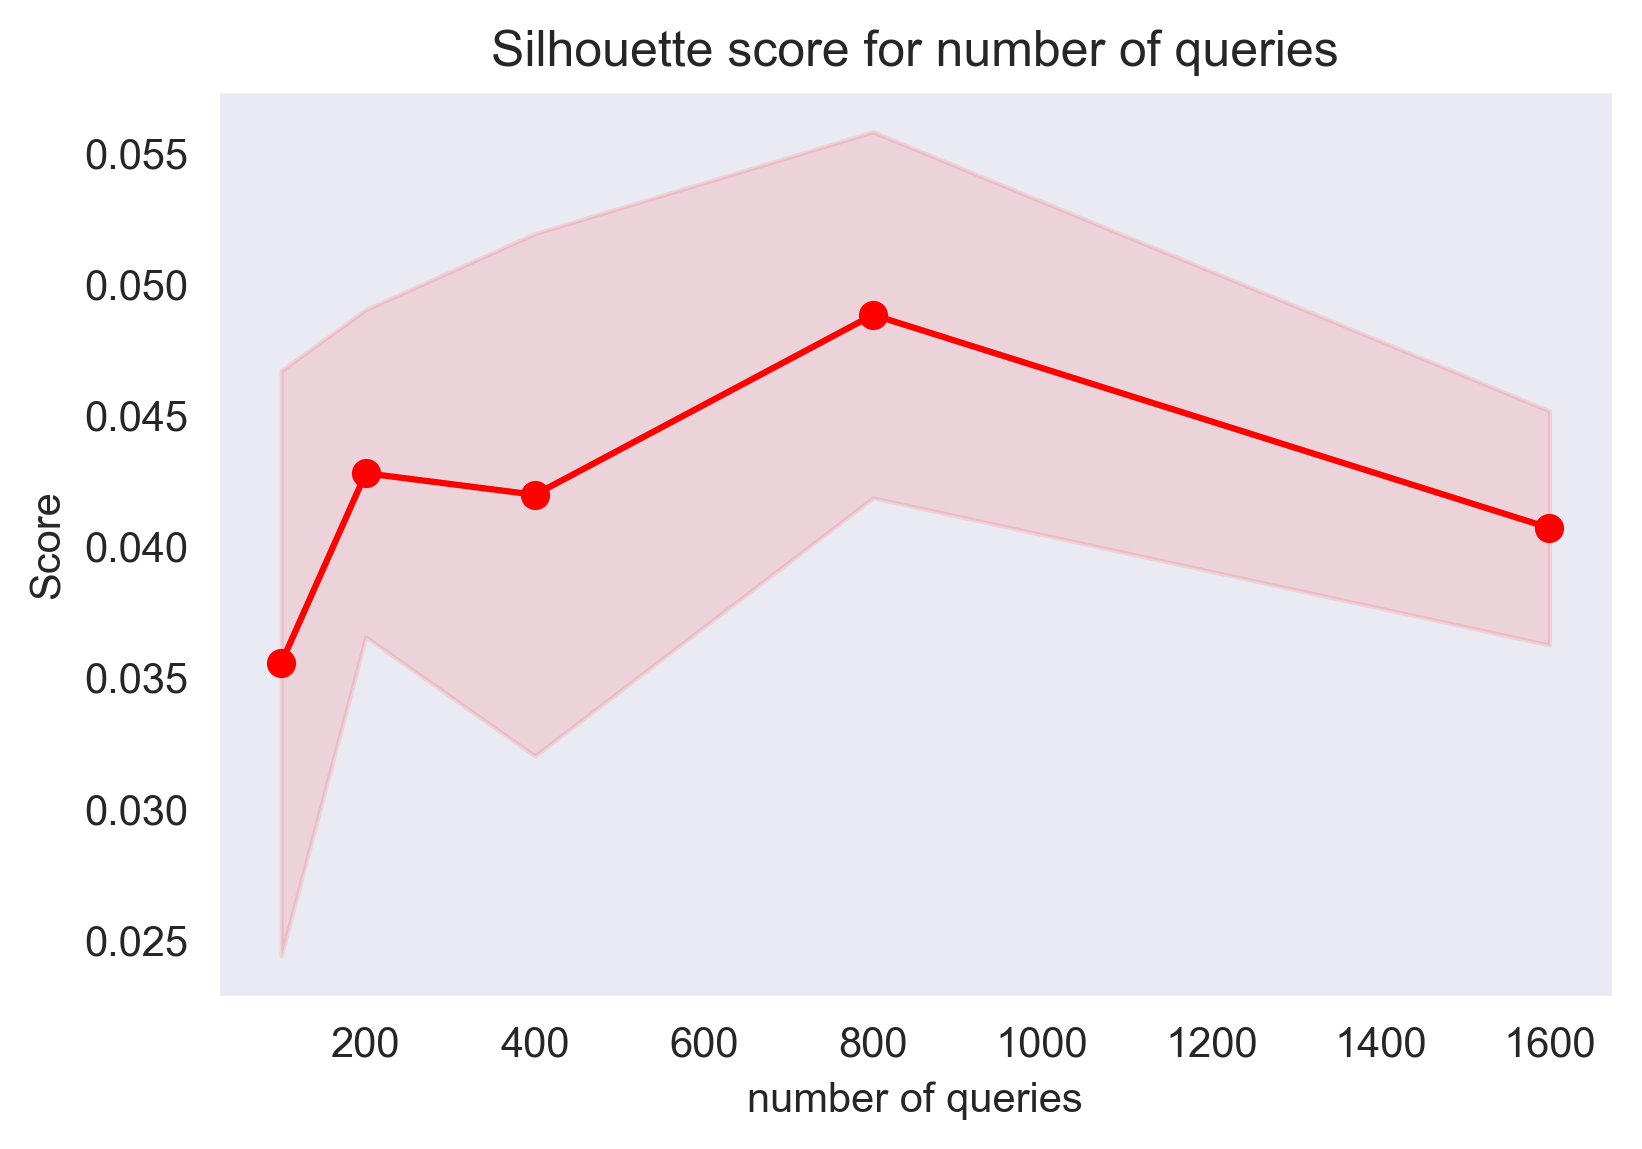

In [67]:
fig, ax = plt.subplots(1, 1)
fig.dpi=300
ax.set_title("Silhouette score for number of queries")
ax.set_xlabel("number of queries")
ax.set_ylabel("Score")
score_arr=np.array(values_sil)
train_scores_mean = np.mean(score_arr, axis=1)
train_scores_std = np.std(score_arr, axis=1)
ax.grid()
ax.fill_between(querry_counts, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
ax.plot(querry_counts, train_scores_mean, 'o-', color="r",
            label="Training score")
#ax.tick_params(labelsize=text_fontsize)
#ax.legend(loc="best", fontsize=text_fontsize)
plt.show()

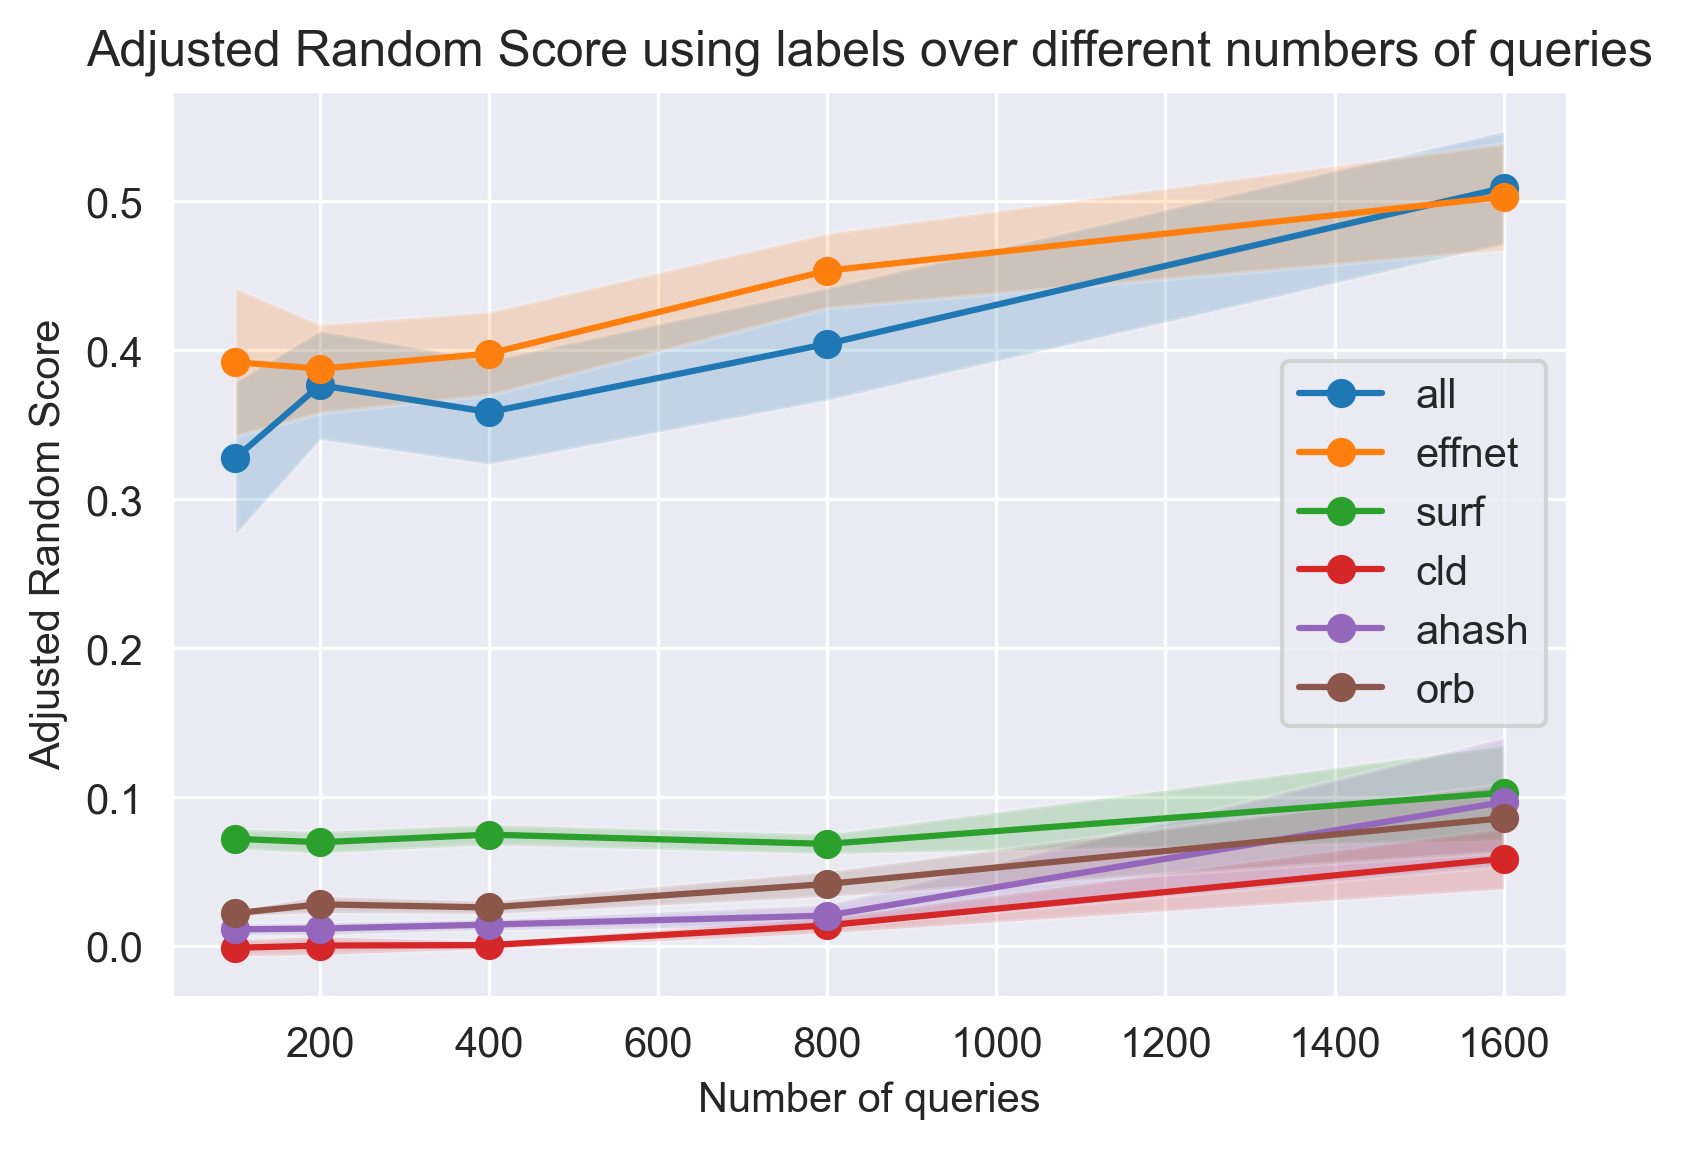

In [68]:
fig, ax = plt.subplots(1, 1)
fig.dpi=300
ax.set_title("Adjusted Random Score using labels over different numbers of queries")
ax.set_xlabel("Number of queries")
ax.set_ylabel("Adjusted Random Score")
#dict_random={"surf":values_random_surf,"cld":values_random_cld,"ahash":values_random_hash}
dict_random={"all":values_random,"effnet":values_random_effnet,"surf":values_random_surf,"cld":values_random_cld,"ahash":values_random_hash,"orb":values_random_orb}
for key in dict_random:
    score_arr=np.array(dict_random[key])
    train_scores_mean = np.mean(score_arr, axis=1)
    train_scores_std = np.std(score_arr, axis=1)
    ax.grid()
    ax.fill_between(querry_counts, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.2)
    ax.plot(querry_counts, train_scores_mean, 'o-',
                label=key)
#ax.tick_params(labelsize=text_fontsizew)
#ax.legend(loc="best", fontsize=text_fontsize)
plt.legend()
plt.show()

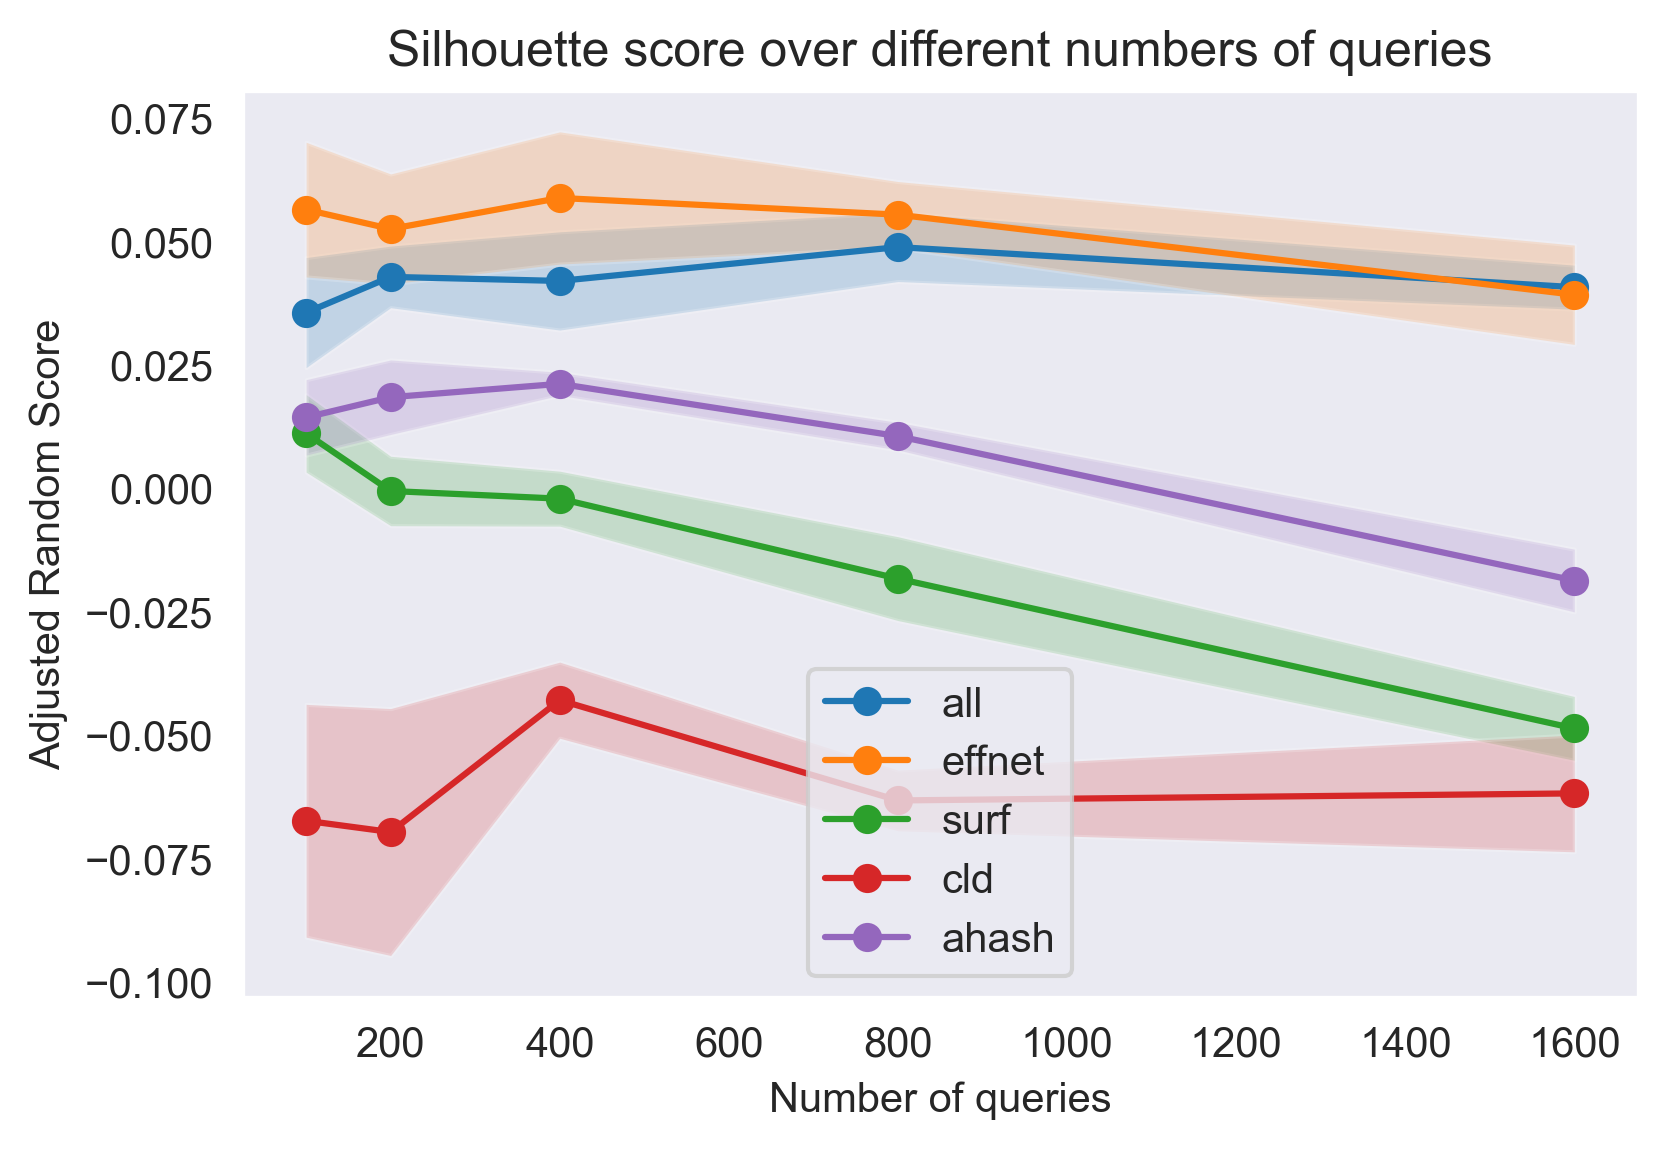

In [69]:
fig, ax = plt.subplots(1, 1)
fig.dpi=300
ax.set_title("Silhouette score over different numbers of queries")
ax.set_xlabel("Number of queries")
ax.set_ylabel("Adjusted Random Score")
#dict_random={"surf":values_random_surf,"cld":values_random_cld,"ahash":values_random_hash}
dict_random={"all":values_sil,"effnet":values_sil_effnet,"surf":values_sil_surf,"cld":values_sil_cld,"ahash":values_sil_hash}
for key in dict_random:
    score_arr=np.array(dict_random[key])
    train_scores_mean = np.mean(score_arr, axis=1)
    train_scores_std = np.std(score_arr, axis=1)
    ax.grid()
    ax.fill_between(querry_counts, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.2)
    ax.plot(querry_counts, train_scores_mean, 'o-',
                label=key)
#ax.tick_params(labelsize=text_fontsizew)
#ax.legend(loc="best", fontsize=text_fontsize)
plt.legend()
plt.show()

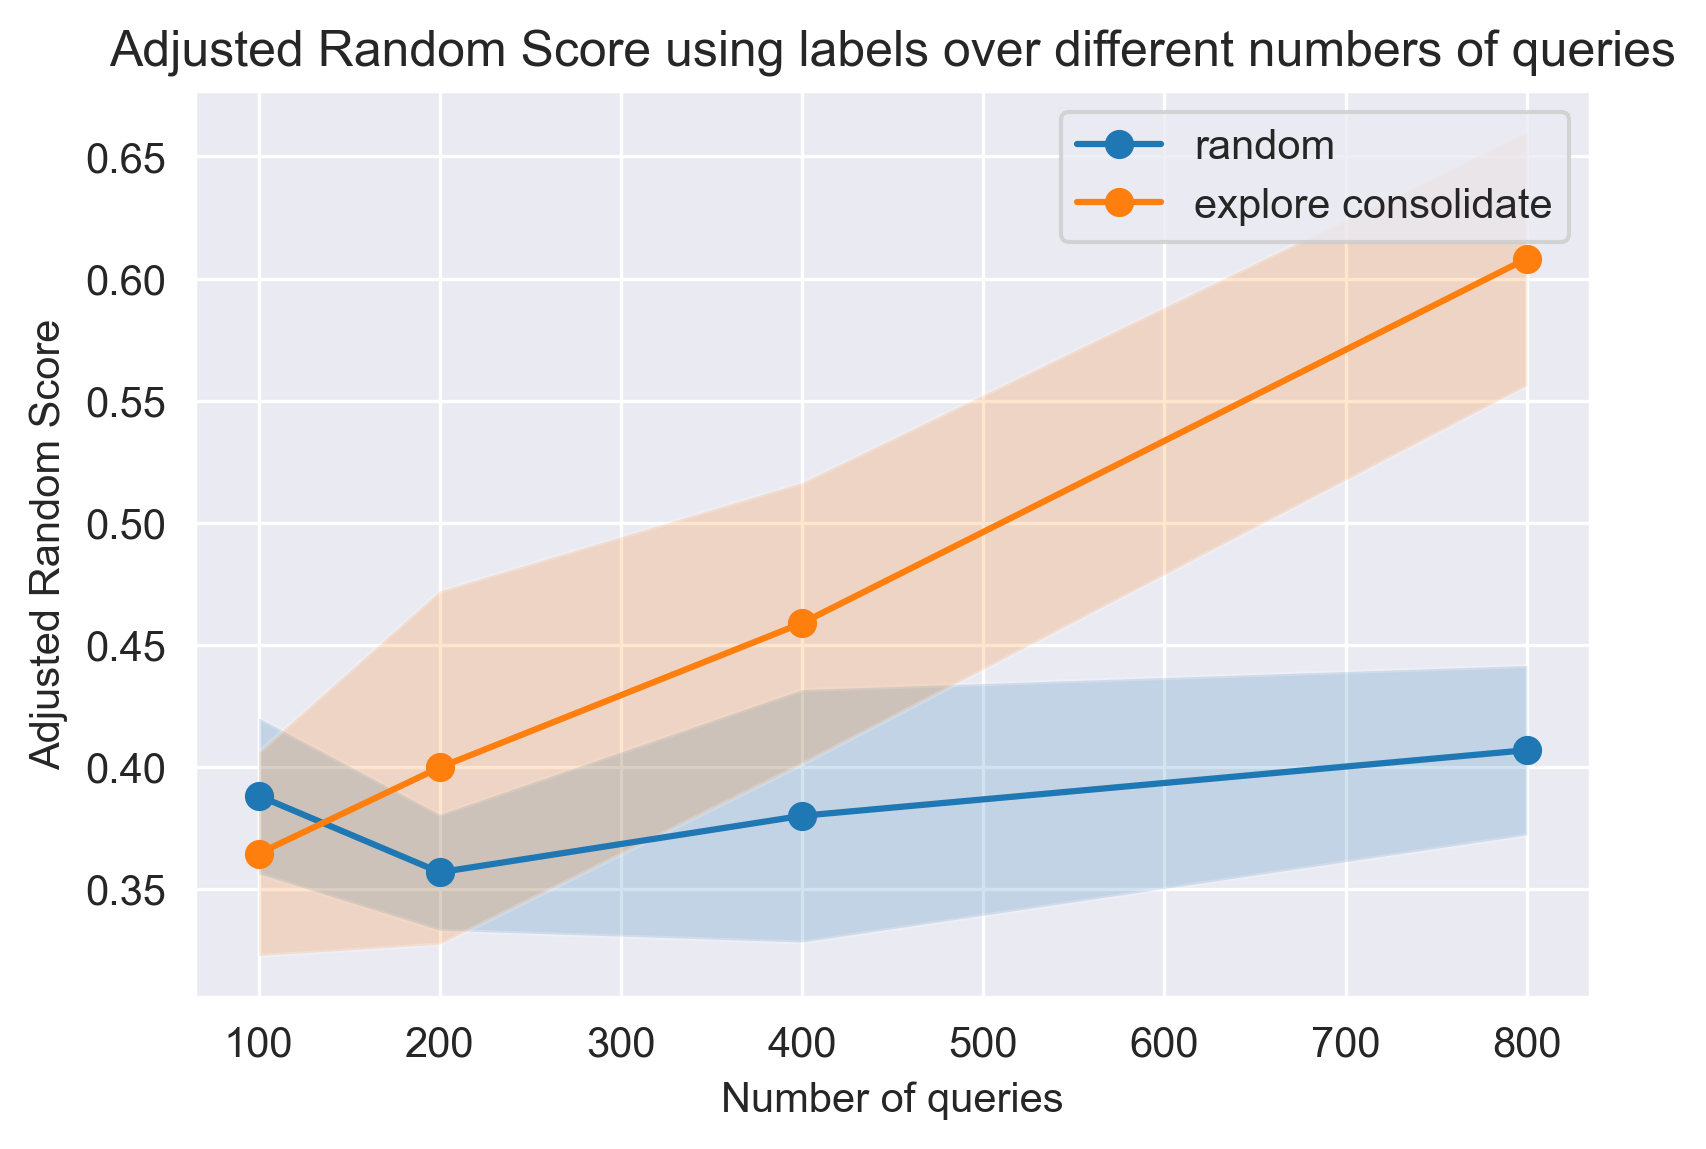

In [70]:

fig, ax = plt.subplots(1, 1)
fig.dpi=300
ax.set_title("Adjusted Random Score using labels over different numbers of queries")
ax.set_xlabel("Number of queries")
ax.set_ylabel("Adjusted Random Score")
#dict_random={"surf":values_random_surf,"cld":values_random_cld,"ahash":values_random_hash}
dict_random={"random":values_random_random,"explore consolidate":values_random_explore}
for key in dict_random:
    score_arr=np.array(dict_random[key])
    train_scores_mean = np.mean(score_arr, axis=1)
    train_scores_std = np.std(score_arr, axis=1)
    ax.grid()
    ax.fill_between(querry_counts2, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.2)
    ax.plot(querry_counts2, train_scores_mean, 'o-',
                label=key)
#ax.tick_params(labelsize=text_fontsizew)
#ax.legend(loc="best", fontsize=text_fontsize)
plt.legend()
plt.show()

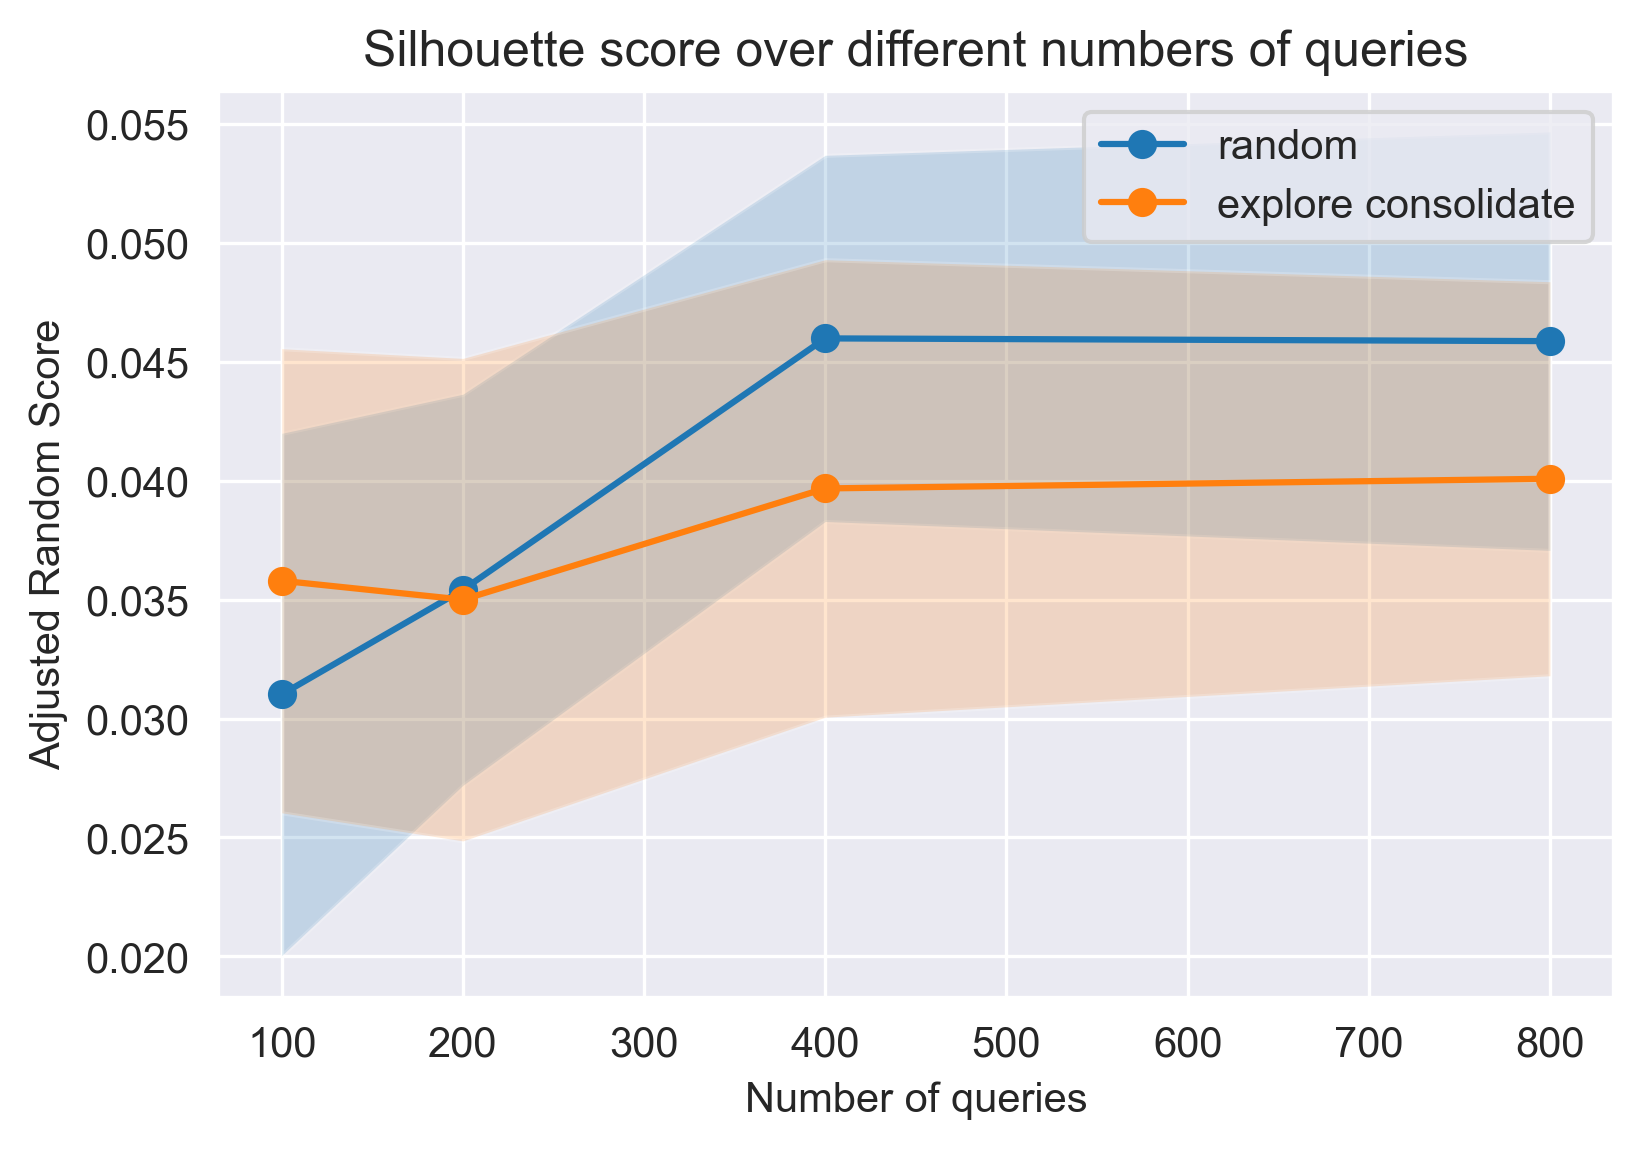

In [71]:
fig, ax = plt.subplots(1, 1)
fig.dpi=300
ax.set_title("Silhouette score over different numbers of queries")
ax.set_xlabel("Number of queries")
ax.set_ylabel("Adjusted Random Score")
#dict_random={"surf":values_random_surf,"cld":values_random_cld,"ahash":values_random_hash}
dict_random={"random":values_sil_random,"explore consolidate":values_sil_explore}
for key in dict_random:
    score_arr=np.array(dict_random[key])
    train_scores_mean = np.mean(score_arr, axis=1)
    train_scores_std = np.std(score_arr, axis=1)
    ax.grid()
    ax.fill_between(querry_counts2, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.2)
    ax.plot(querry_counts2, train_scores_mean, 'o-',
                label=key)
#ax.tick_params(labelsize=text_fontsizew)
#ax.legend(loc="best", fontsize=text_fontsize)
plt.legend()
plt.show()

In [ ]:
values_random=[]
querry_counts=[]
for i in range (5):
    cnt=100*(2**(i))
    querry_counts.append(cnt)
    values_random_per_try=[]
    for k in range(16):
        oracle = LabelOracle(train_filtered_list, max_queries_cnt=cnt,max_querry=True)
        #Gives way more constraints by trying to find neighboorhoods, but ammount is random
        #active_learner = active_semi_clustering.active.pairwise_constraints.explore_consolidate.ExploreConsolidate(n_clusters=20)
        active_learner = active_semi_clustering.active.pairwise_constraints.random.Random(n_clusters=n_cluster)
        active_learner.fit(features, oracle)
        pairwise_constraints = active_learner.pairwise_constraints_
        pck = PCKMeans(n_clusters=n_cluster*2,max_iter=100,w=500)
        try:
            pck.fit(features, ml=pairwise_constraints[0], cl=pairwise_constraints[1])
            values_random_per_try.append(metrics.adjusted_rand_score(y, pck.labels_))
        except Exception as e:
            if str(e) == "KeyboardInterrupt":
                raise
            else:
                print(e)
            pass
    values_random.append(values_random_per_try)
    print(np.mean(values_random_per_try))

In [ ]:
import types
def initialize_cluster_centers(self,X, neighborhoods):
        cluster_centers = X[np.random.choice(X.shape[0], self.n_clusters, replace=False), :]
        return cluster_centers


for i in range (5):
    avg_random=[]
    for k in range(16):
        oracle = LabelOracle(train_filtered_list, max_queries_cnt=100*(2**(i)),max_querry=True)
        #Gives way more constraints by trying to find neighboorhoods, but ammount is random
        #active_learner = active_semi_clustering.active.pairwise_constraints.explore_consolidate.ExploreConsolidate(n_clusters=20)
        active_learner = active_semi_clustering.active.pairwise_constraints.random.Random(n_clusters=n_cluster)
        active_learner.fit(features, oracle)
        pairwise_constraints = active_learner.pairwise_constraints_
        pck = PCKMeans(n_clusters=n_cluster,max_iter=100,w=500)
        pck._initialize_cluster_centers=types.MethodType( initialize_cluster_centers, pck )
        try:
            pck.fit(features, ml=pairwise_constraints[0], cl=pairwise_constraints[1])
            avg_random.append(metrics.adjusted_rand_score(y, pck.labels_))
        except:
            pass
    print(np.mean(avg_random))


In [ ]:
#pca = PCA(n_components=80)
#features2=pca.fit_transform(features)

In [ ]:
import types
pck = PCKMeans(n_clusters=n_cluster,max_iter=100,w=500)
#This overrides init with random init
#pck._initialize_cluster_centers=types.MethodType( initialize_cluster_centers, pck )
#actually random often does better than using the center of the found classes
pck.fit(features, ml=pairwise_constraints[0], cl=pairwise_constraints[1])
metrics.adjusted_rand_score(y, pck.labels_)
#metrics.calinski_harabasz_score(features, clusterer.labels_)

In [ ]:
features.shape

In [ ]:
clusterer = COPKMeans(n_clusters=n_cluster,max_iter=100)
clusterer.fit(features, ml=pairwise_constraints[0], cl=pairwise_constraints[1])
metrics.adjusted_rand_score(y, clusterer.labels_)
#metrics.calinski_harabasz_score(features, clusterer.labels_)

In [ ]:
kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(features)
metrics.adjusted_rand_score(y, kmeans.predict(features))
#metrics.calinski_harabasz_score(features, kmeans.predict(features))


In [ ]:
def cluster_histogramm(data,predicted_values,y,use_all=True):
    unique, counts = np.unique(predicted_values, return_counts=True)
    n_clusters=len(unique)
    counter=np.zeros((n_clusters,20))
    for i in range(len(predicted_values)):
        if(use_all):
            for k in data[i]["labels"]:
                    counter[predicted_values[i],k]+=1
        else:
            counter[predicted_values[i],y[i]]+=1
            
    return counter
hist=cluster_histogramm(train_filtered_list,pck.labels_,y,use_all=False)

for i in range(hist.shape[0]):  
    print(i)
    fig = plt.gcf()
    fig.set_size_inches(16, 6.5)
    plt.bar(np.arange(0,20),hist[i],tick_label=_VOC_LABELS) 
    plt.show()

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_distances
def classifier_function_creator(clusterer,distance_measure):
    cluster_algo=clusterer
    dist_func=distance_measure
    def classifier_function(image):
        image*=255.0
        ds=tf.data.Dataset.from_tensor_slices({"image":image})
        feature= data_pre.add_features_to_dataset(ds,None).map(lambda x:x["feature"]).batch(image.shape[0]).get_single_element()
        
        dist= dist_func(feature,cluster_algo.cluster_centers_)

        dist=1/dist
        dist=np.power(dist,20)
        dist=dist/np.sum(dist,axis=1,keepdims=True)
        return dist
    return classifier_function
    

func1=classifier_function_creator(pck,euclidean_distances)
print(func1(np.expand_dims(train_filtered_list[0]["image"],axis=0)/255.0))
#func2=clasifier_function_creator(pck,cosine_distances)
#func2(np.expand_dims(train_filtered_list[0]["image"],axis=0)/255.0)
#print(func1(np.expand_dims(train_filtered_list[0]["image"],axis=0)/255.0))


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB

clf2 = RandomForestClassifier(max_depth=10, random_state=0)

from sklearn.metrics import accuracy_score


def classifier_function_creator2(classifier,features,labels):
    clf=classifier
    clf.fit(features,labels)
    print(accuracy_score(clf.predict(features),labels))
    def classifier_function(image):
        image*=255.0
        ds=tf.data.Dataset.from_tensor_slices({"image":image})
        feature= data_pre.add_features_to_dataset(ds,None).map(lambda x:x["feature"]).batch(image.shape[0]).get_single_element()
        return clf.predict_proba(feature)
    
    return classifier_function


In [ ]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

explained_index=0
explanation1 = explainer.explain_instance(train_filtered_list[explained_index]["image"]/255.0, classifier_function_creator(pck,euclidean_distances),labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], top_labels=20, hide_color=0, num_samples=1000,batch_size =250)
    


In [ ]:
#pred =kmeans.predict(features)
#print(pred[explained_index])
print(pck.labels_[explained_index])

In [ ]:

from skimage.segmentation import mark_boundaries
temp, mask = explanation1.get_image_and_mask(14, positive_only=False, num_features=25, hide_rest=False)
plt.imshow(mark_boundaries(temp/1.5, mask))

In [ ]:
explanation2 = explainer.explain_instance(train_filtered_list[explained_index]["image"]/255.0, classifier_function_creator2(clf2,features,pck.labels_),labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], top_labels=20, hide_color=0, num_samples=1000,batch_size =250)

In [ ]:
from skimage.segmentation import mark_boundaries
temp2, mask2 = explanation2.get_image_and_mask(5, positive_only=False, num_features=25, hide_rest=False)
plt.imshow(mark_boundaries(temp2/1.5, mask2))

In [ ]:
x1 = np.array(list(train_complete.map(lambda x: x['effnet']).as_numpy_iterator()), dtype=np.float64)

In [ ]:
kmeans1 = KMeans(n_clusters=200, random_state=0).fit(x1)

In [ ]:

if EFFNET_ENABLED:
    counter = 0
    for data in val_complete:
        if counter == 10:
            break
        im = data['image']
        feature = data['effnet']
        pred = kmeans1.predict(tf.reshape(feature, (1, -1)))
        for i in range(pred.shape[0]):
            if pred[i] == 4:
                plt.imshow(im)
                plt.show()
                counter += 1
                if counter == 10:
                    break

In [ ]:
x2 = np.array(list(train_complete.map(lambda x: x['surf']).as_numpy_iterator()), dtype=np.float64)
#scaler=RobustScaler()
#x2 = scaler.fit_transform(x2)

In [ ]:
kmeans2 = KMeans(n_clusters=200, random_state=0).fit(x2)

In [ ]:
if SURF_ENABLED:
    counter = 0
    for data in train_complete:
        if counter == 10:
            break
        im = data['image']
        feature = data['surf']
        pred = kmeans2.predict(tf.reshape(feature, (1, -1)))
        for i in range(pred.shape[0]):
            if pred[i] == 2:
                plt.imshow(im)
                plt.show()
                counter += 1
                if counter == 10:
                    break

In [ ]:
test_kmeans = KMeans(n_clusters=20, random_state=0).fit(features)

test_feature_1 = np.array(list(train_filtered.map(lambda x: x['surf']).as_numpy_iterator()), dtype=np.float64)
test_kmeans_1 = KMeans(n_clusters=20, random_state=0).fit(test_feature_1)

test_feature_2 = np.array(list(train_filtered.map(lambda x: x['effnet']).as_numpy_iterator()), dtype=np.float64)
test_kmeans_2 = KMeans(n_clusters=20, random_state=0).fit(test_feature_2)

test_feature_3 = np.array(list(train_filtered.map(lambda x: x['cld']).as_numpy_iterator()), dtype=np.float64)
test_kmeans_3 = KMeans(n_clusters=20, random_state=0).fit(test_feature_3)

test_feature_4 = np.array(list(train_filtered.map(lambda x: x['hash']).as_numpy_iterator()), dtype=np.float64)
test_kmeans_4 = KMeans(n_clusters=20, random_state=0).fit(test_feature_4)

In [ ]:
from sklearn import metrics
import seaborn as sns

def get_metric_scores(X, predicted_y, true_y):
    met_adrand = metrics.adjusted_rand_score(true_y, predicted_y)
    met_nmi = metrics.normalized_mutual_info_score(true_y, predicted_y)
    met_eucsil = metrics.silhouette_score(X, predicted_y, metric='euclidean')
    met_cossil = metrics.silhouette_score(X, predicted_y, metric='cosine')
    return met_adrand, met_nmi, met_eucsil, met_cossil
    
metric_scores_all = get_metric_scores(features, test_kmeans.labels_, y)

metric_scores_1 = get_metric_scores(test_feature_1, test_kmeans_1.labels_, y)
metric_scores_2 = get_metric_scores(test_feature_2, test_kmeans_2.labels_, y)
metric_scores_3 = get_metric_scores(test_feature_3, test_kmeans_3.labels_, y)
metric_scores_4 = get_metric_scores(test_feature_4, test_kmeans_4.labels_, y)

metric_array = np.array([metric_scores_all, metric_scores_1, metric_scores_2, metric_scores_3, metric_scores_4])

fig, ax =plt.subplots(1,5)
plt.subplots_adjust(wspace=0.5)
sns.set_style("whitegrid")
#bar_plot_1 = sns.barplot(x=['adjusted_rand_score', 'normalized_mutual_information_score', 'euclidean_silhouette_score', 'cosine_silhouette_score'], y=np.array(metric_scores))

for i in range(5):
    bar_plot_1 = sns.barplot(x=['adjusted_rand_score', 'normalized_mutual_information_score', 'euclidean_silhouette_score', 'cosine_silhouette_score'], y=metric_array[i], ax=ax[i])
#bar_plot_2 = sns.barplot(x=['adjusted_rand_score', 'normalized_mutual_information_score', 'euclidean_silhouette_score', 'cosine_silhouette_score'], y=np.array(metric_scores_1), ax=ax[1])

    bar_plot_1.set(ylim=(-1, 1))
    bar_plot_1.set(title='All features')
    bar_plot_1.set_xticklabels(
        bar_plot_1.get_xticklabels(), 
        rotation=35, 
        horizontalalignment='right',
        fontsize=8)

# bar_plot_2.set(ylim=(-1, 1))
# bar_plot_2.set(title='Only x feature')
# bar_plot_2.set_xticklabels(
#     bar_plot_2.get_xticklabels(), 
#     rotation=35, 
#     horizontalalignment='right',
#     fontsize=8
    
# )
fig.show()





In [ ]:
print(metric_scores_all, '\n', metric_scores_1, '\n', metric_scores_2, '\n', metric_scores_3, '\n', metric_scores_4)
#print(metric_scores)

In [ ]:
def get_n_ind_close_to_cluster(n, cluster, kmeans_handle, X):
    d = kmeans_handle.transform(X)[:, cluster]
    ind = np.argsort(d)[:n]
    return ind

In [ ]:
test_ind_c = get_n_ind_close_to_cluster(15, 4, test_kmeans, features)

In [ ]:
print('True max label:', np.array(y)[test_ind_c])
print('Predicted label:', test_kmeans.labels_[test_ind_c])